# Task Description

In [52]:
# The task would be to test a long-only stock-based carry/value strategy.

# Carry strategy in stocks would be to long high dividend yield stocks and short the reverse (in this case no need to do short).
# Whole value strategy you should be familiar with.

# Carry trade in rate hike periods work pretty well (for fx especially). We are interested in whether the same hold for value. 
# The underlying assets would be S&P 500 stocks.

# Please take into account that some companies do stock repurchase instead of cash dividend.
# You could try to find adjusted dividend yield data. Time horizon is up to you, but keep in mind potential survivorship bias.
# It might be interesting to check the strategy performance during different periods. 
# Remember to make the backtest a way that they could be implemented (not longing 100 stocks at the same time). 
# Have a nice night and good luck with your presentation on Monday.

# Setup

## Load Packages

In [53]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scipy as sp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # to calculate the MSE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from statsmodels.graphics.tsaplots import plot_acf # To produce ACF plots
from statsmodels.graphics.tsaplots import plot_pacf # To produce PACF plots
from statsmodels.tsa.seasonal import seasonal_decompose # To decompose Seasons
from statsmodels.tsa.stattools import adfuller, kpss # Tests for Stationarity
from statsmodels.tsa.ar_model import AutoReg # To produce AR models
from statsmodels.stats.anova import anova_lm # To use ANOVA (compare nested models)
from statsmodels.tsa.arima.model import ARIMA # To build ARMA & ARIMA Models
import statsmodels.stats.diagnostic as dg # To get Breusch-Godfrey Test
from statsmodels.stats.stattools import durbin_watson



from datetime import datetime # to transform variables into datetime objects
import math # simple math functions
from math import sqrt # square root function
import statistics # descriptive statistics library
import scipy.stats as stats # descriptive statistics library from scipy
import matplotlib.dates as mdates # date formatting
from matplotlib.collections import PolyCollection, LineCollection # better plot options

## Useful functions for Matrix calculations

In [54]:
def f(x, y): 
    return x + y                             
vecsum = np.vectorize(f)     # Use pd.DataFrame(vecsum(A,B)) to get df of elementwise sum

In [55]:
def g(x, y): 
    return x - y                             
vecdif = np.vectorize(g)     # Use pd.DataFrame(vecdif(A,B)) to get df of elementwise differences

In [56]:
def h(x, y): 
    return x * y                             
vecmult = np.vectorize(h)    # Use pd.DataFrame(vecmult(A,B)) to get df of elementwise multiplication

In [57]:
def i(x, y): 
    return x / y                             
vecdiv = np.vectorize(i)    # Use pd.DataFrame(vecdiv(A,B)) to get df of elementwise division

### Illustrative Example extra für de Herr Vogel

In [58]:
# Chasch de shit au lösche wenns checkt hesch aber mir hets na easy gholfe
A = [[1, 2, 3], 
    [3, 5, 6],
    [7, 8, 9]]
A = pd.DataFrame(A)
A.columns = ["ret1", "ret2", "ret3"]

B = [[0.2, 0.3, 0.5], 
    [0.1, 0.6, 0.3],
    [0.4, 0.2, 0.4]]
B = pd.DataFrame(B)    
B.columns = ["w1", "w2", "w3"]


In [59]:
A

ret1  ret2  ret3
0     1     2     3
1     3     5     6
2     7     8     9

In [60]:
B

w1   w2   w3
0  0.2  0.3  0.5
1  0.1  0.6  0.3
2  0.4  0.2  0.4

In [61]:
pd.DataFrame(vecsum(A,B))

0    1    2
0  1.2  2.3  3.5
1  3.1  5.6  6.3
2  7.4  8.2  9.4

In [62]:
pd.DataFrame(vecdif(A,B))

0    1    2
0  0.8  1.7  2.5
1  2.9  4.4  5.7
2  6.6  7.8  8.6

In [63]:
pd.DataFrame(vecmult(A,B))

0    1    2
0  0.2  0.6  1.5
1  0.3  3.0  1.8
2  2.8  1.6  3.6

In [64]:
pd.DataFrame(vecdiv(A,B))

0          1     2
0   5.0   6.666667   6.0
1  30.0   8.333333  20.0
2  17.5  40.000000  22.5

## Plotstyle

In [65]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

## LoadData

In [66]:
# Loading Data

data_px = pd.read_excel("02_Data_clean/SPX_px_clean.xlsx", parse_dates=["Date"])
data_px_yly = pd.read_excel("02_Data_clean/SPX_px_clean_yearly.xlsx", parse_dates=["Date"])
data_bv = pd.read_excel("02_Data_clean/SPX_value_clean.xlsx", parse_dates=["Date"])

date_fix = pd.read_excel("02_Data_clean/SPX_px_clean.xlsx")

# Check
print(type(data_bv))
print(data_bv.dtypes)

<class 'pandas.core.frame.DataFrame'>
Date                  datetime64[ns]
AEE UN Equity                float64
ITT UN Equity                float64
UN UN Equity                 float64
APD UN Equity                float64
                           ...      
NTAP UQ Equity               float64
CTXS UQ Equity               float64
9990253D UN Equity           float64
0948669D UN Equity           float64
CMCSK UQ Equity              float64
Length: 501, dtype: object


## Data Cleaning

In [67]:
# Resample monthly returns
data_px.set_index("Date", inplace=True) # set datetimeindex
data_bv.set_index("Date", inplace=True) # set datetimeindex
data_px_yly.set_index("Date", inplace=True) # set datetimeindex
semian_ret = data_px.pct_change(fill_method = None).resample("2BQ").agg(lambda x: ((1+x).prod()-1)) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns
# df = pd.concat([data, data2], axis=1) # concating dfs


In [68]:
semian_ret = semian_ret.iloc[1: , :]


date_fix['Date'] = date_fix['Date'].replace(['1999-12-31'], '1999-06-30')
date_fix.set_index("Date", inplace=True) # set datetimeindex

midyear_ret = date_fix.pct_change(fill_method = None).resample("4BQ").agg(lambda x: ((1+x).prod()-1)) # pct_change creates ordinary returns

In [69]:
midyear_ret = midyear_ret.iloc[1:-1, :]
midyear_ret

AEE UN Equity  ITT UN Equity  UN UN Equity  APD UN Equity  \
Date                                                                    
2000-06-30       0.030534      -0.091601     -0.210104      -0.081937   
2001-06-29       0.265185       0.456809      0.385354       0.484787   
2002-06-28       0.007260       0.595472      0.087794       0.103168   
2003-06-30       0.025110      -0.085974     -0.166514      -0.186249   
2004-06-30      -0.006577       0.295979      0.257175       0.266130   
2005-06-30       0.244292       0.163939     -0.042857       0.144616   
2006-06-30      -0.073394       0.017053      0.040931       0.073924   
2007-06-29      -0.029505       0.379392      0.375610       0.257353   
2008-06-30      -0.156091      -0.091678     -0.099613       0.227075   
2009-06-30      -0.406915      -0.290554     -0.118153      -0.338978   
2010-06-30      -0.011007       0.063868      0.143727       0.052002   
2011-06-30       0.164880       0.201022      0.129570       0.355934   
2012-06-29       0.186837      -0.055860      0.048083      -0.131842   
2013-06-28       0.026834       0.671023      0.178711       0.134274   
2014-06-30       0.179152       0.639238      0.105317       0.404500   
2015-06-30      -0.070918      -0.141464      0.003682       0.104735   
2016-06-30       0.372648      -0.206330     -0.003898      -0.013795   
2017-06-30       0.055609       0.223135      0.272330       0.104357   
2018-06-29       0.113042       0.300896      0.008142       0.088564   
2019-06-28       0.234347       0.252726      0.089734       0.453606   
2020-06-30      -0.082679      -0.131032     -0.102273       0.042629   
2021-06-30       0.186357       0.608436      0.109888       0.222524   
2022-06-30       0.075483      -0.239948      0.000000      -0.126360   

            RDPL UN Equity  GOLD UN Equity  VZ UN Equity  CAT UN Equity  \
Date                                                                      
2000-06-30        0.018614        0.028269     -0.174619      -0.280214   
2001-06-29       -0.053482       -0.167010      0.052892       0.477491   
2002-06-28       -0.051484        0.253465     -0.249534      -0.021978   
2003-06-30       -0.153971       -0.073196     -0.012204       0.140552   
2004-06-30        0.118050        0.165909     -0.098082       0.399785   
2005-06-30        0.209832        0.214425     -0.036345       0.239411   
2006-06-30       -0.033043        0.187801     -0.028430       0.537890   
2007-06-29        0.000000       -0.017905      0.275782       0.051289   
2008-06-30        0.000000        0.547988     -0.163623      -0.058110   
2009-06-30        0.000000       -0.221556     -0.095976      -0.531390   
2010-06-30        0.000000        0.322581     -0.078735       0.872396   
2011-06-30        0.000000       -0.071012      0.349487       0.545511   
2012-06-29        0.000000       -0.127091      0.234444      -0.150985   
2013-06-28        0.000000       -0.581049      0.132763      -0.028501   
2014-06-30        0.000000        0.144854     -0.020262       0.318705   
2015-06-30        0.000000       -0.395117     -0.034469      -0.201875   
2016-06-30        0.000000        0.877982      0.143007      -0.158834   
2017-06-30        0.000000       -0.222765     -0.179497       0.471450   
2018-06-29        0.000000       -0.174733      0.126511       0.262516   
2019-06-28        0.000000        0.201066      0.135560       0.004570   
2020-06-30        0.000000        0.640457     -0.069491      -0.101988   
2021-06-30        0.000000       -0.192501      0.060572       0.767383   
2022-06-30        0.000000       -0.101005     -0.096133      -0.142481   

            CVX UN Equity  KO UN Equity  ...  PTC UQ Equity  QCOM UQ Equity  \
Date                                     ...                                  
2000-06-30      -0.020922     -0.013947  ...      -0.593534       -0.659333   
2001-06-29       0.067058     -0.216541  ...       0.271818       -0.0253

### Create Book to Market Dataframe

In [70]:
# Divide BVPS yearly by SP yearly to get Book to market signal yearly
data_btm = pd.DataFrame(vecdiv(data_bv, data_px_yly))

In [71]:
# Set Datetimeindex again
data_btm.set_index(data_px_yly.index, inplace=True) # set datetimeindex

# Strategy

## Calculate Desired Weights

In [72]:
# The approach is as follows: 
# 1. Take Book to market value as BVPS(t-6mt) / SP(t-6mt)
# 2. for each month calculate the 10 stocks considered for the long strategy
# 3. calculate the PF return
# 4. take into account the transaction costs

In [73]:

cols = (data_btm.columns[0:])
rows = (data_btm.iloc[:,0])

des_weight = pd.DataFrame(index = rows, columns = (cols))
des_weight.set_index(data_px_yly.index, inplace=True) # set datetimeindex
des_weight

0    1    2    3    4    5    6    7    8    9    ...  490  491  \
Date                                                          ...             
1999-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2000-12-29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2001-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2002-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2003-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2004-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2005-12-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2006-12-29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2007-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2008-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2009-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2010-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2011-12-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2012-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2013-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2014-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2015-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2016-12-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2017-12-29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2018-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2019-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2020-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2021-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

            492  493  494  495  496  497  498  499  
Date                                                
1999-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2000-12-29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2001-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2002-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2003-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2004-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2005-12-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2006-12-29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2007-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2008-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2009-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2010-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2011-12-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2012-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2013-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2014-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2015-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2016-12-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-12-29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2020-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[23 rows x 500 columns]

In [74]:
for i in data_btm.index:
    x = data_btm.loc[i,:].nlargest(10)
    for j in data_btm.columns:
        if j in x.index:
            des_weight.loc[i,j] = 0.1
        else:
            des_weight.loc[i,j] = 0
des_weight = des_weight.set_index(midyear_ret.index)

## Weighted Returns on 30. June

In [75]:
weighted_ret = pd.DataFrame(vecmult(des_weight, midyear_ret))

In [76]:
weighted_ret.set_index(midyear_ret.index, inplace=True) # set datetimeindex

## PF returns weighted per year

In [77]:
ones500x1 = np.ones(500)
pd.DataFrame(ones500x1)

0
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
..   ...
495  1.0
496  1.0
497  1.0
498  1.0
499  1.0

[500 rows x 1 columns]

In [78]:
pf_ret_unadj = np.matmul(weighted_ret,ones500x1)
pf_ret_unadj = pd.DataFrame(pf_ret_unadj)
pf_ret_unadj.columns =["PF_returns_unadjusted"]
pf_ret_unadj.loc["2000-06-30"] = 0.0 #bc we do not make returns in first period
pf_ret_unadj

PF_returns_unadjusted
Date                             
2000-06-30               0.000000
2001-06-29               0.340499
2002-06-28              -0.275046
2003-06-30               0.015931
2004-06-30               0.384665
2005-06-30               0.049902
2006-06-30               0.021248
2007-06-29               0.164872
2008-06-30              -0.209292
2009-06-30              -0.334376
2010-06-30               0.242559
2011-06-30               0.007231
2012-06-29              -0.030265
2013-06-28               0.202431
2014-06-30               0.011996
2015-06-30              -0.032700
2016-06-30              -0.077383
2017-06-30              -0.002307
2018-06-29               0.562650
2019-06-28              -0.253817
2020-06-30              -0.247794
2021-06-30               0.430771
2022-06-30              -0.062908

## Actual weights

In [79]:
# 1+return -> for stock returns and for the weighted PF returns -> used for actual weights calculation
midyear_ret_gross = midyear_ret.transform(lambda x: x + 1)
pf_ret_unadj_gross = pf_ret_unadj.transform(lambda x: x + 1)

In [80]:
# Create (23x500) matrix to match midyear return matrix for scaling factor to calculate adjusted weights
ones_matrix = np.ones((23,500))
pf_ret_unadj_gross_matrix = pd.DataFrame(vecmult(pf_ret_unadj_gross, ones_matrix))

In [81]:
# Calculate weight scaling factor by deviding the returns of the assets, per year by the weighted pf return per year
weight_scaleFactor = pd.DataFrame(vecdiv(midyear_ret_gross,pf_ret_unadj_gross_matrix), columns = midyear_ret_gross.columns, index = midyear_ret_gross.index)

In [82]:
des_weight

0    1   2   3   4   5   6   7   8   9    ... 490 491 492 493 494  \
Date                                                 ...                       
2000-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2001-06-29   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2002-06-28   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2003-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2004-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2005-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2006-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2007-06-29   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2008-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2009-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2010-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2011-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2012-06-29   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2013-06-28   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2014-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2015-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2016-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2017-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2018-06-29   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2019-06-28   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2020-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2021-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2022-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

           495 496 497  498  499  
Date                              
2000-06-30   0   0   0    0    0  
2001-06-29   0   0   0    0    0  
2002-06-28   0   0   0    0    0  
2003-06-30   0   0   0    0  0.1  
2004-06-30   0   0   0    0    0  
2005-06-30   0   0   0    0    0  
2006-06-30   0   0   0    0    0  
2007-06-29   0   0   0    0    0  
2008-06-30   0   0   0    0    0  
2009-06-30   0   0   0    0    0  
2010-06-30   0   0   0    0    0  
2011-06-30   0   0   0    0    0  
2012-06-29   0   0   0    0    0  
2013-06-28   0   0   0    0    0  
2014-06-30   0   0   0    0    0  
2015-06-30   0   0   0  0.1    0  
2016-06-30   0   0   0  0.1    0  
2017-06-30   0   0   0  0.1    0  
2018-06-29   0   0   0    0    0  
2019-06-28   0   0   0    0    0  
2020-06-30   0   0   0    0    0  
2021-06-30   0   0   0    0    0  
2022-06-30   0   0   0    0    0  

[23 rows x 500 columns]

In [83]:
# Shift by -1 to create w(t-1) but last row becomes N/A
des_weight_lag1 = des_weight.shift(1)

In [84]:
# Calculate actual weights before rebalancing
actual_weight = pd.DataFrame(vecmult(des_weight_lag1, weight_scaleFactor), columns = weight_scaleFactor.columns, index = weight_scaleFactor.index)
actual_weight

AEE UN Equity  ITT UN Equity  UN UN Equity  APD UN Equity  \
Date                                                                    
2000-06-30            NaN            NaN           NaN            NaN   
2001-06-29            0.0       0.108677           0.0            0.0   
2002-06-28            0.0       0.000000           0.0            0.0   
2003-06-30            0.0       0.000000           0.0            0.0   
2004-06-30            0.0       0.000000           0.0            0.0   
2005-06-30            0.0       0.110862           0.0            0.0   
2006-06-30            0.0       0.099589           0.0            0.0   
2007-06-29            0.0       0.118416           0.0            0.0   
2008-06-30            0.0       0.114875           0.0            0.0   
2009-06-30            0.0       0.000000           0.0            0.0   
2010-06-30            0.0       0.000000           0.0            0.0   
2011-06-30            0.0       0.000000           0.0            0.0   
2012-06-29            0.0       0.097361           0.0            0.0   
2013-06-28            0.0       0.000000           0.0            0.0   
2014-06-30            0.0       0.000000           0.0            0.0   
2015-06-30            0.0       0.000000           0.0            0.0   
2016-06-30            0.0       0.000000           0.0            0.0   
2017-06-30            0.0       0.000000           0.0            0.0   
2018-06-29            0.0       0.000000           0.0            0.0   
2019-06-28            0.0       0.000000           0.0            0.0   
2020-06-30            0.0       0.000000           0.0            0.0   
2021-06-30            0.0       0.000000           0.0            0.0   
2022-06-30            0.0       0.000000           0.0            0.0   

            RDPL UN Equity  GOLD UN Equity  VZ UN Equity  CAT UN Equity  \
Date                                                                      
2000-06-30             NaN             NaN           NaN            NaN   
2001-06-29             0.0             0.0           0.0            0.0   
2002-06-28             0.0             0.0           0.0            0.0   
2003-06-30             0.0             0.0           0.0            0.0   
2004-06-30             0.0             0.0           0.0            0.0   
2005-06-30             0.0             0.0           0.0            0.0   
2006-06-30             0.0             0.0           0.0            0.0   
2007-06-29             0.0             0.0           0.0            0.0   
2008-06-30             0.0             0.0           0.0            0.0   
2009-06-30             0.0             0.0           0.0            0.0   
2010-06-30             0.0             0.0           0.0            0.0   
2011-06-30             0.0             0.0           0.0            0.0   
2012-06-29             0.0             0.0           0.0            0.0   
2013-06-28             0.0             0.0           0.0            0.0   
2014-06-30             0.0             0.0           0.0            0.0   
2015-06-30             0.0             0.0           0.0            0.0   
2016-06-30             0.0             0.0           0.0            0.0   
2017-06-30             0.0             0.0           0.0            0.0   
2018-06-29             0.0             0.0           0.0            0.0   
2019-06-28             0.0             0.0           0.0            0.0   
2020-06-30             0.0             0.0           0.0            0.0   
2021-06-30             0.0             0.0           0.0            0.0   
2022-06-30             0.0             0.0           0.0            0.0   

            CVX UN Equity  KO UN Equity  ...  PTC UQ Equity  QCOM UQ Equity  \
Date                                     ...                                  
2000-06-30            NaN           NaN  ...            NaN             NaN   
2001-06-29            0.0           0.0  ...            0.0             0

## Turnover

In [85]:
des_weight

0    1   2   3   4   5   6   7   8   9    ... 490 491 492 493 494  \
Date                                                 ...                       
2000-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2001-06-29   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2002-06-28   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2003-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2004-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2005-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2006-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2007-06-29   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2008-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2009-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2010-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2011-06-30   0  0.1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2012-06-29   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2013-06-28   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2014-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2015-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2016-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2017-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2018-06-29   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2019-06-28   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2020-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2021-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2022-06-30   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

           495 496 497  498  499  
Date                              
2000-06-30   0   0   0    0    0  
2001-06-29   0   0   0    0    0  
2002-06-28   0   0   0    0    0  
2003-06-30   0   0   0    0  0.1  
2004-06-30   0   0   0    0    0  
2005-06-30   0   0   0    0    0  
2006-06-30   0   0   0    0    0  
2007-06-29   0   0   0    0    0  
2008-06-30   0   0   0    0    0  
2009-06-30   0   0   0    0    0  
2010-06-30   0   0   0    0    0  
2011-06-30   0   0   0    0    0  
2012-06-29   0   0   0    0    0  
2013-06-28   0   0   0    0    0  
2014-06-30   0   0   0    0    0  
2015-06-30   0   0   0  0.1    0  
2016-06-30   0   0   0  0.1    0  
2017-06-30   0   0   0  0.1    0  
2018-06-29   0   0   0    0    0  
2019-06-28   0   0   0    0    0  
2020-06-30   0   0   0    0    0  
2021-06-30   0   0   0    0    0  
2022-06-30   0   0   0    0    0  

[23 rows x 500 columns]

In [86]:
actual_weight

AEE UN Equity  ITT UN Equity  UN UN Equity  APD UN Equity  \
Date                                                                    
2000-06-30            NaN            NaN           NaN            NaN   
2001-06-29            0.0       0.108677           0.0            0.0   
2002-06-28            0.0       0.000000           0.0            0.0   
2003-06-30            0.0       0.000000           0.0            0.0   
2004-06-30            0.0       0.000000           0.0            0.0   
2005-06-30            0.0       0.110862           0.0            0.0   
2006-06-30            0.0       0.099589           0.0            0.0   
2007-06-29            0.0       0.118416           0.0            0.0   
2008-06-30            0.0       0.114875           0.0            0.0   
2009-06-30            0.0       0.000000           0.0            0.0   
2010-06-30            0.0       0.000000           0.0            0.0   
2011-06-30            0.0       0.000000           0.0            0.0   
2012-06-29            0.0       0.097361           0.0            0.0   
2013-06-28            0.0       0.000000           0.0            0.0   
2014-06-30            0.0       0.000000           0.0            0.0   
2015-06-30            0.0       0.000000           0.0            0.0   
2016-06-30            0.0       0.000000           0.0            0.0   
2017-06-30            0.0       0.000000           0.0            0.0   
2018-06-29            0.0       0.000000           0.0            0.0   
2019-06-28            0.0       0.000000           0.0            0.0   
2020-06-30            0.0       0.000000           0.0            0.0   
2021-06-30            0.0       0.000000           0.0            0.0   
2022-06-30            0.0       0.000000           0.0            0.0   

            RDPL UN Equity  GOLD UN Equity  VZ UN Equity  CAT UN Equity  \
Date                                                                      
2000-06-30             NaN             NaN           NaN            NaN   
2001-06-29             0.0             0.0           0.0            0.0   
2002-06-28             0.0             0.0           0.0            0.0   
2003-06-30             0.0             0.0           0.0            0.0   
2004-06-30             0.0             0.0           0.0            0.0   
2005-06-30             0.0             0.0           0.0            0.0   
2006-06-30             0.0             0.0           0.0            0.0   
2007-06-29             0.0             0.0           0.0            0.0   
2008-06-30             0.0             0.0           0.0            0.0   
2009-06-30             0.0             0.0           0.0            0.0   
2010-06-30             0.0             0.0           0.0            0.0   
2011-06-30             0.0             0.0           0.0            0.0   
2012-06-29             0.0             0.0           0.0            0.0   
2013-06-28             0.0             0.0           0.0            0.0   
2014-06-30             0.0             0.0           0.0            0.0   
2015-06-30             0.0             0.0           0.0            0.0   
2016-06-30             0.0             0.0           0.0            0.0   
2017-06-30             0.0             0.0           0.0            0.0   
2018-06-29             0.0             0.0           0.0            0.0   
2019-06-28             0.0             0.0           0.0            0.0   
2020-06-30             0.0             0.0           0.0            0.0   
2021-06-30             0.0             0.0           0.0            0.0   
2022-06-30             0.0             0.0           0.0            0.0   

            CVX UN Equity  KO UN Equity  ...  PTC UQ Equity  QCOM UQ Equity  \
Date                                     ...                                  
2000-06-30            NaN           NaN  ...            NaN             NaN   
2001-06-29            0.0           0.0  ...            0.0             0

In [87]:
turnover = pd.DataFrame(abs(vecdif(des_weight, actual_weight)), index = weight_scaleFactor.index)
turnover.loc["2000-06-30",:] = des_weight.loc["2000-06-30",:] # Adjust for buying the whole portfolio at the 30.06.2000
turnover

0         1    2    3    4    5    6    7    8    9    ...  490  \
Date                                                               ...        
2000-06-30  0.0  0.100000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2001-06-29  0.0  0.108677  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2002-06-28  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2003-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2004-06-30  0.0  0.100000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2005-06-30  0.0  0.010862  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2006-06-30  0.0  0.000411  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2007-06-29  0.0  0.018416  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2008-06-30  0.0  0.114875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2009-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2010-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2011-06-30  0.0  0.100000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2012-06-29  0.0  0.097361  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2013-06-28  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2014-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2015-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2016-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2017-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2018-06-29  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2019-06-28  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2020-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2021-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2022-06-30  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

            491  492  493  494  495  496  497       498       499  
Date                                                               
2000-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2001-06-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2002-06-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2003-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.100000  
2004-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.068584  
2005-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2006-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2007-06-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2008-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2009-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2010-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2011-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2012-06-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2013-06-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2014-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2015-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.100000  0.000000  
2016-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.008387  0.000000  
2017-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000231  0.000000  
2018-06-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.063994  0.000000  
2019-06-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2020-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2021-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  
2022-06-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  

[23 rows x 500 columns]

In [88]:
turnover_yly = np.matmul(turnover,ones500x1)
turnover_yly = pd.DataFrame(turnover_yly, columns = ["Yearly Turnover of PF"])
turnover_yly

Yearly Turnover of PF
Date                             
2000-06-30               1.000000
2001-06-29               1.782873
2002-06-28               1.499348
2003-06-30               0.961053
2004-06-30               0.662733
2005-06-30               0.965762
2006-06-30               0.732010
2007-06-29               0.675869
2008-06-30               1.183595
2009-06-30               1.018281
2010-06-30               0.509524
2011-06-30               0.608099
2012-06-29               0.865597
2013-06-28               0.643945
2014-06-30               0.839858
2015-06-30               0.686570
2016-06-30               0.469696
2017-06-30               0.337964
2018-06-29               1.065260
2019-06-28               1.041248
2020-06-30               1.266461
2021-06-30               1.077150
2022-06-30               0.469449

# Adjust Portfolio Return for Transaction cost and turnover

In [89]:
# Calculate transaction costs yearly by multiplying turnover and transaction costs
c = np.ones(len(turnover_yly)) * 0.002 # 0.2% from Ziegler Slides -> transaction cost corresponding to turnover in %
c = pd.DataFrame(c)
tc_yly = pd.DataFrame(vecmult(turnover_yly,c), index=turnover_yly.index, columns= ["TC_yly"])
tc_yly

TC_yly
Date                
2000-06-30  0.002000
2001-06-29  0.003566
2002-06-28  0.002999
2003-06-30  0.001922
2004-06-30  0.001325
2005-06-30  0.001932
2006-06-30  0.001464
2007-06-29  0.001352
2008-06-30  0.002367
2009-06-30  0.002037
2010-06-30  0.001019
2011-06-30  0.001216
2012-06-29  0.001731
2013-06-28  0.001288
2014-06-30  0.001680
2015-06-30  0.001373
2016-06-30  0.000939
2017-06-30  0.000676
2018-06-29  0.002131
2019-06-28  0.002082
2020-06-30  0.002533
2021-06-30  0.002154
2022-06-30  0.000939

In [90]:
pf_ret_unadj

PF_returns_unadjusted
Date                             
2000-06-30               0.000000
2001-06-29               0.340499
2002-06-28              -0.275046
2003-06-30               0.015931
2004-06-30               0.384665
2005-06-30               0.049902
2006-06-30               0.021248
2007-06-29               0.164872
2008-06-30              -0.209292
2009-06-30              -0.334376
2010-06-30               0.242559
2011-06-30               0.007231
2012-06-29              -0.030265
2013-06-28               0.202431
2014-06-30               0.011996
2015-06-30              -0.032700
2016-06-30              -0.077383
2017-06-30              -0.002307
2018-06-29               0.562650
2019-06-28              -0.253817
2020-06-30              -0.247794
2021-06-30               0.430771
2022-06-30              -0.062908

In [91]:
pf_ret_adj = pd.DataFrame(vecdif(pf_ret_unadj, tc_yly), index = tc_yly.index, columns = ["PF_ret_adj"])
pf_ret_adj

PF_ret_adj
Date                  
2000-06-30   -0.002000
2001-06-29    0.336933
2002-06-28   -0.278044
2003-06-30    0.014009
2004-06-30    0.383340
2005-06-30    0.047970
2006-06-30    0.019784
2007-06-29    0.163521
2008-06-30   -0.211659
2009-06-30   -0.336412
2010-06-30    0.241540
2011-06-30    0.006015
2012-06-29   -0.031996
2013-06-28    0.201144
2014-06-30    0.010317
2015-06-30   -0.034073
2016-06-30   -0.078322
2017-06-30   -0.002983
2018-06-29    0.560519
2019-06-28   -0.255900
2020-06-30   -0.250327
2021-06-30    0.428616
2022-06-30   -0.063847

# Plot Results

In [92]:
pf_ret_adj_gross = pf_ret_adj.transform(lambda x: x + 1)
pf_ret_adj_gross_cum = pf_ret_adj_gross.cumprod() # We don't start at one bc of initial costs for buying pf
pf_ret_unadj_gross_cum = pf_ret_unadj_gross.cumprod() # We don't start at one bc of initial costs for buying pf

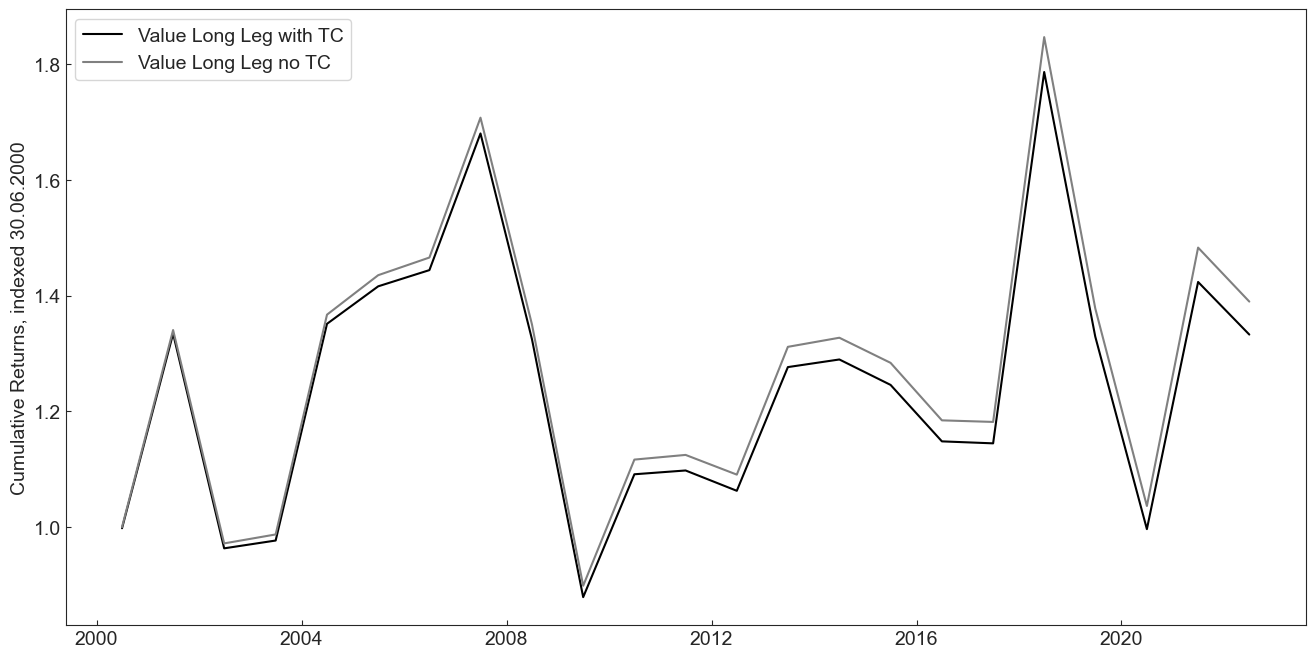

In [93]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Value Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Value Long Leg no TC", color="grey")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
plt.savefig("03_Figures/Value_Performance_20y")

# Performance Statistics

In [94]:
pf_ret_adj.describe()

PF_ret_adj
count   23.000000
mean     0.037745
std      0.236452
min     -0.336412
25%     -0.071084
50%      0.006015
75%      0.182332
max      0.560519